# Exercise 7

Text Generation using LSTM

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tokenizer = Tokenizer()

!wget --no-check-certificate \
    https://raw.githubusercontent.com/cibernox/storyteller/refs/heads/master/snow-white.txt \
    -O /tmp/snowwhite.txt

data = open('/tmp/snowwhite.txt').read()

--2025-05-27 09:19:45--  https://raw.githubusercontent.com/cibernox/storyteller/refs/heads/master/snow-white.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [text/plain]
Saving to: ‘/tmp/snowwhite.txt’

/tmp/snowwhite.txt  100%[===================>]   1.48K  --.-KB/s    in 0s      

2025-05-27 09:19:45 (20.2 MB/s) - ‘/tmp/snowwhite.txt’ saved [1520/1520]



In [3]:
# Preprocess and tokenize the corpus
corpus = [line.strip() for line in data.lower().split("\n") if line.strip()]

# Fit tokenizer and calculate vocabulary size
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# Generate n-gram sequences more efficiently
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    # Skip lines that couldn't be tokenized or are too short
    if len(token_list) < 2:
        continue

    # Generate n-grams from 2 to full length
    for i in range(2, len(token_list) + 1):
        input_sequences.append(token_list[:i])

# Handle empty sequences case
if not input_sequences:
    raise ValueError("No valid sequences generated. Check your input data.")

# Pad sequences efficiently
max_sequence_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Split into predictors and labels
predictors = input_sequences[:, :-1]
labels = input_sequences[:, -1]

# Convert labels to categorical (one-hot encoding)
labels = ku.to_categorical(labels, num_classes=total_words)

print(f"Vocabulary size: {total_words}")
print(f"Number of sequences: {len(input_sequences)}")
print(f"Max sequence length: {max_sequence_len}")
print(f"Predictor shape: {predictors.shape}")
print(f"Label shape: {labels.shape}")

Vocabulary size: 161
Number of sequences: 245
Max sequence length: 11
Predictor shape: (245, 10)
Label shape: (245, 161)


# 1. Build an LSTM

In [4]:
model = Sequential()
model.add(Embedding(total_words, 512, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(1024, return_sequences=True)))
model.add(Dropout(0.55))
model.add(LSTM(256))
model.add(Dense(128, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), ))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',           # Metric to monitor
    patience=50,                  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,    # Restore model weights from the best epoch
    verbose=1                     # Print message when stopping
)

# Save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',     # Path to save the model
    monitor='val_loss',           # Metric to monitor
    save_best_only=True,          # Only save when the model is considered the "best"
    save_weights_only=False,      # Save the entire model, not just weights
    verbose=1                     # Print message when saving
)

# Reduce learning rate when learning stagnates
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # Metric to monitor
    factor=0.5,                   # Factor by which the learning rate will be reduced
    patience=20,                  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,                  # Lower bound on the learning rate
    verbose=1                     # Print message when reducing learning rate
)

# Log training metrics to CSV file
csv_logger = CSVLogger(
    filename='training_log.csv',  # Path to save the log file
    separator=',',                # Separator to use in the CSV file
    append=False                  # Overwrite the file if it exists
)

# Combine all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, csv_logger]

# Train the model with validation split and callbacks
history = model.fit(
    predictors,
    labels,
    epochs=200,
    verbose=1,
    validation_split=0.15,
    callbacks=callbacks_list,     # Add callbacks
    batch_size=100                 # Optional: specify batch size
)

Epoch 1/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0100 - loss: 5.1153
Epoch 1: val_loss improved from inf to 5.07599, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 594ms/step - accuracy: 0.0098 - loss: 5.1126 - val_accuracy: 0.0270 - val_loss: 5.0760 - learning_rate: 0.0010
Epoch 2/200
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0825 - loss: 4.9338
Epoch 2: val_loss did not improve from 5.07599
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0773 - loss: 4.9236 - val_accuracy: 0.0000e+00 - val_loss: 5.4180 - learning_rate: 0.0010
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0526 - loss: 4.7609
Epoch 3: val_loss did not improve from 5.07599
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0527 - loss: 4.7664 - val_accuracy: 0.0270 - val_loss: 5.2677 - learning_rate: 0.0010
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0888 - loss: 4.7154 
Epoch 4: val_loss did not improve from 5.07599
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0883 - loss: 4.7104 - val_accuracy: 0.0270 - val_loss: 5.4869 - learning_rate: 0.0010
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/ste

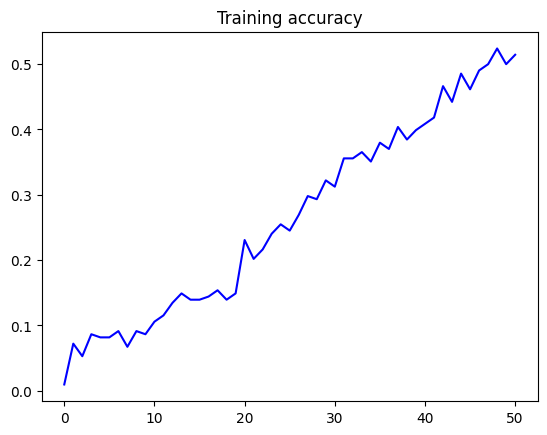

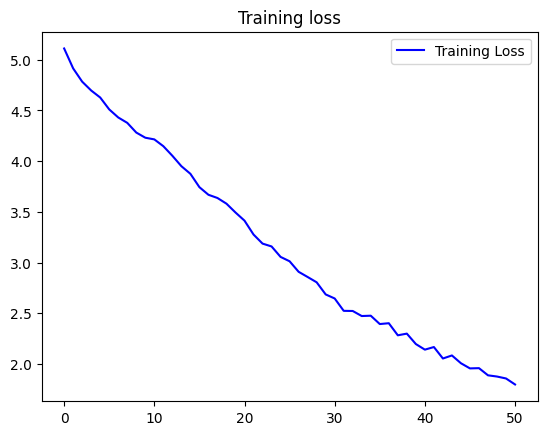

In [6]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## B. Generate texts


In [13]:
# Text generation with temperature sampling
seed_text = "Snow White is"
next_words = 1
temperature = 1.9

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    # Get prediction probabilities instead of argmax
    predictions = model.predict(token_list)[0]

    # Apply temperature scaling
    predictions = np.log(predictions + 1e-8) / temperature  # Add small value to avoid log(0)
    predictions = np.exp(predictions)
    predictions = predictions / np.sum(predictions)  # Normalize to get probabilities

    # Sample from the probability distribution
    predicted = np.random.choice(len(predictions), p=predictions)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Snow White is failed


In [8]:
# Text generation with temperature sampling
seed_text = "Once upon a time"
next_words = 30
temperature = 1.8  # Adjust between 0.1 (conservative) and 2.0 (creative)

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    # Get prediction probabilities instead of argmax
    predictions = model.predict(token_list)[0]

    # Apply temperature scaling
    predictions = np.log(predictions + 1e-8) / temperature  # Add small value to avoid log(0)
    predictions = np.exp(predictions)
    predictions = predictions / np.sum(predictions)  # Normalize to get probabilities

    # Sample from the probability distribution
    predicted = np.random.choice(len(predictions), p=predictions)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

2. "Snow White lived in the forest with..."

In [9]:
# Text generation with temperature sampling
seed_text = "Snow White lived in the forest with"
next_words = 30
temperature = 1.8  # Adjust between 0.1 (conservative) and 2.0 (creative)

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    # Get prediction probabilities instead of argmax
    predictions = model.predict(token_list)[0]

    # Apply temperature scaling
    predictions = np.log(predictions + 1e-8) / temperature  # Add small value to avoid log(0)
    predictions = np.exp(predictions)
    predictions = predictions / np.sum(predictions)  # Normalize to get probabilities

    # Sample from the probability distribution
    predicted = np.random.choice(len(predictions), p=predictions)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

3. "The queen looked into the mirror and said..."

In [10]:
# Text generation with temperature sampling
seed_text = "The queen looked into the mirror and said"
next_words = 30
temperature = 1.8  # Adjust between 0.1 (conservative) and 2.0 (creative)

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    # Get prediction probabilities instead of argmax
    predictions = model.predict(token_list)[0]

    # Apply temperature scaling
    predictions = np.log(predictions + 1e-8) / temperature  # Add small value to avoid log(0)
    predictions = np.exp(predictions)
    predictions = predictions / np.sum(predictions)  # Normalize to get probabilities

    # Sample from the probability distribution
    predicted = np.random.choice(len(predictions), p=predictions)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

4. "One day, Snow White found a small cottage and..."

In [11]:
# Text generation with temperature sampling
seed_text = "One day, Snow White found a small cottage and"
next_words = 30
temperature = 1.8  # Adjust between 0.1 (conservative) and 2.0 (creative)

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    # Get prediction probabilities instead of argmax
    predictions = model.predict(token_list)[0]

    # Apply temperature scaling
    predictions = np.log(predictions + 1e-8) / temperature  # Add small value to avoid log(0)
    predictions = np.exp(predictions)
    predictions = predictions / np.sum(predictions)  # Normalize to get probabilities

    # Sample from the probability distribution
    predicted = np.random.choice(len(predictions), p=predictions)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━